# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date
data.set_index('Date', inplace=True)

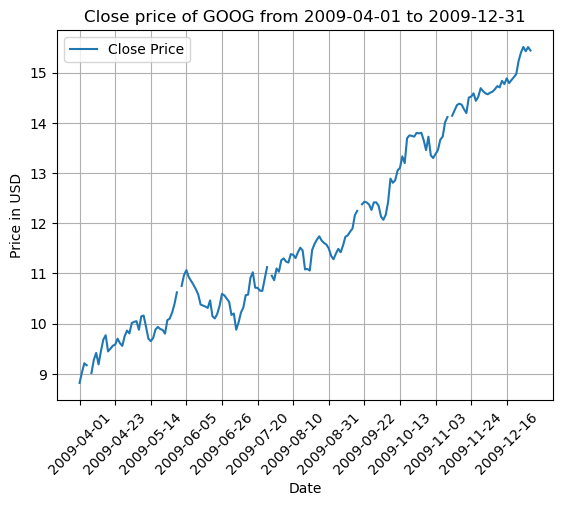

In [5]:
# Plot the Close Data
plt.plot(data['Close'], label='Close Price')

# Plot formatting
plt.title(f'Close price of GOOG from {data.index[0]} to {data.index[-1]}')
plt.xticks(data.index[::15], rotation=45)
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
data.isnull().sum()

Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [7]:
# forward fill missing values
data.ffill(inplace=True)

In [8]:
# Check for null values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

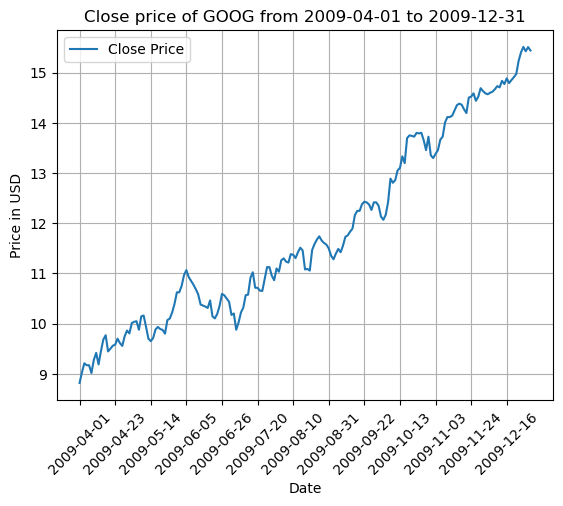

In [9]:
# Plot the cleaned Close Data
plt.plot(data['Close'], label='Close Price')

# Plot formatting
plt.title(f'Close price of GOOG from {data.index[0]} to {data.index[-1]}')
plt.xticks(data.index[::15], rotation=45)
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [10]:
# Calculate 20-day bollinger bands
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['BB_upper'] = data['SMA20'] + (2 * data['STD20'])
data['BB_lower'] = data['SMA20'] - (2 * data['STD20'])

In [11]:
# Remove rows with NaN bollinger bands
data.dropna(inplace=True)

In [12]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
features = ['Close', 'BB_upper', 'BB_lower']
dataset = data[features]

# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [13]:
# Display the Un-normalized Dataset
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,SMA20,STD20,BB_upper,BB_lower
Date,,,,,,,,,,
2009-04-29,9.613217,9.837377,9.609730,9.750204,9.750204,144941247.0,9.395770,0.271027,9.937823,8.853717
2009-04-30,9.857053,10.056057,9.833143,9.862284,9.862284,174881049.0,9.447924,0.254066,9.956057,8.939792
2009-05-01,9.838871,9.902633,9.752196,9.805497,9.805497,97471985.0,9.486766,0.245844,9.978454,8.995079
2009-05-04,9.917078,10.022433,9.832894,10.011973,10.011973,128600225.0,9.526866,0.263121,10.053107,9.000625
2009-05-05,9.962159,10.087191,9.894164,10.037128,10.037128,96391952.0,9.570141,0.272622,10.115385,9.024898
2009-05-06,10.131774,10.168885,9.987564,10.049084,10.049084,105710750.0,9.614014,0.275700,10.165415,9.062614
2009-05-07,10.064775,10.086942,9.775858,9.878224,9.878224,120441759.0,9.657115,0.242734,10.142584,9.171646
2009-05-08,10.033641,10.214962,9.838124,10.145223,10.145223,155183494.0,9.700490,0.248804,10.198098,9.202882
2009-05-11,10.032396,10.261537,9.992545,10.161413,10.161413,102755715.0,9.737688,0.259638,10.256965,9.218412


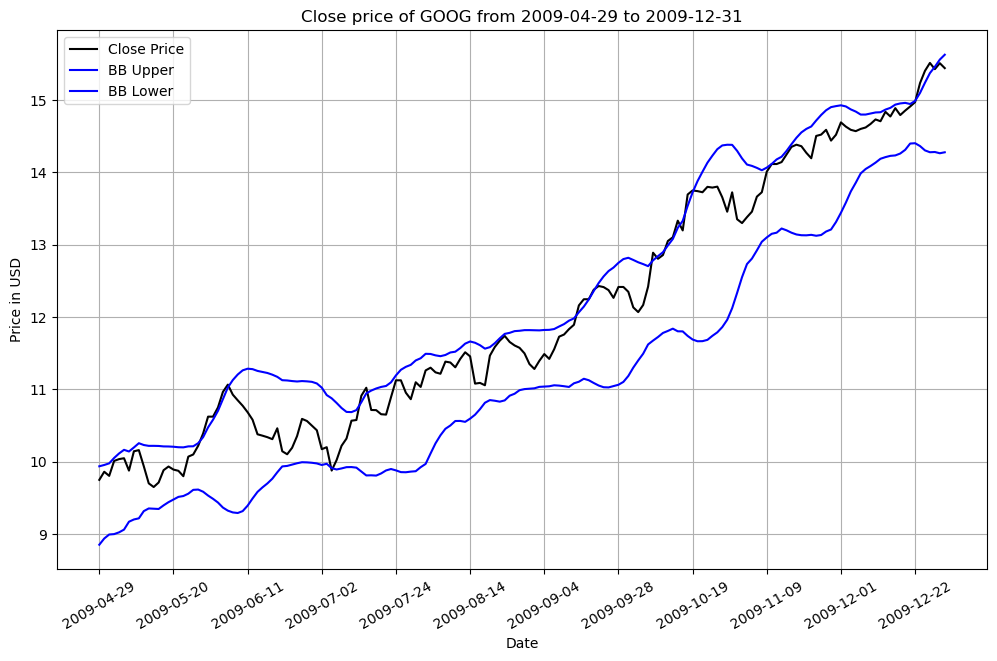

In [14]:
# Plot the Un-normalized Dataset
plt.figure(figsize=(12, 7))
plt.plot(data['Close'], color='k', label='Close Price')
plt.plot(data['BB_upper'], color='b', label='BB Upper')
plt.plot(data['BB_lower'], color='b', label='BB Lower')

# Plot formatting
plt.title(f'Close price of GOOG from {data.index[0]} to {data.index[-1]}')
plt.xticks(data.index[::15], rotation=30)
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

plt.show()

In [15]:
# Normalize Dataset with StandardScaler
normalizers = {}
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]]
    # fit normalizer to column data and append in normlist
    normalizer.fit(column_data)
    # transform column data with the fitted normalizer, and place the transformed data column in out normed_dataset df
    normed_dataset[col] = normalizer.transform(column_data)
    # Store the normalizer for inverse transforms later
    normalizers[col] = normalizer

In [16]:
# Display the normed dataset
display_df(normed_dataset)

,Close,BB_upper,BB_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


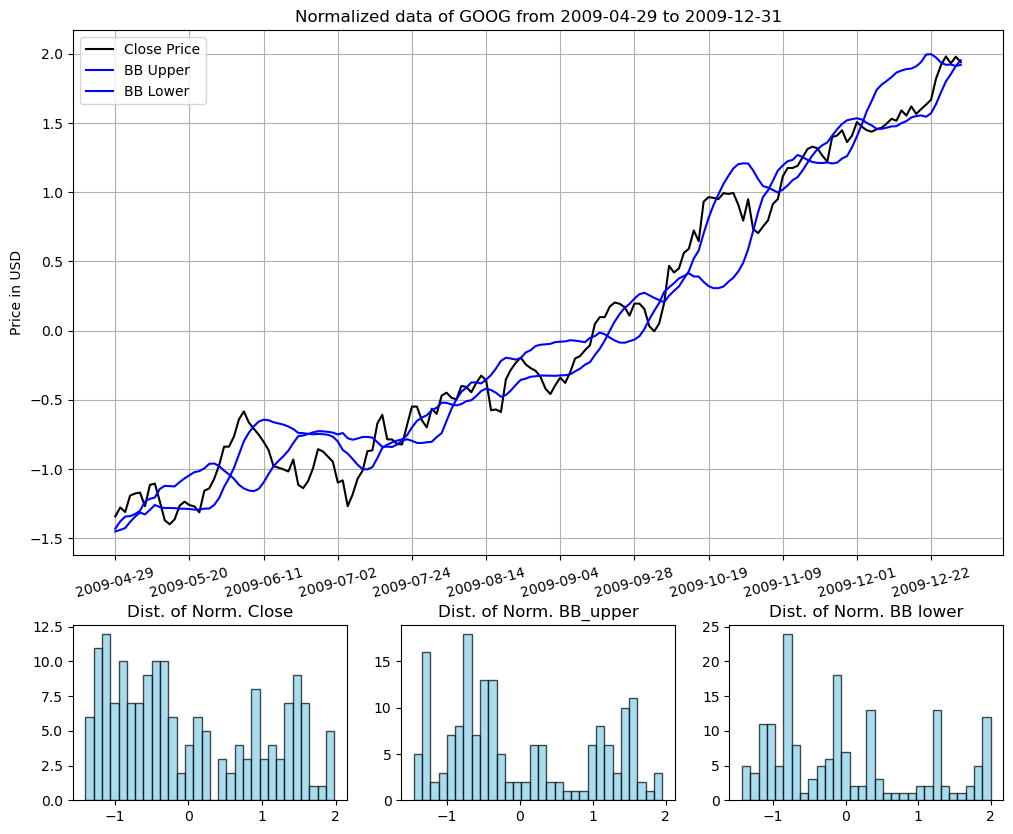

In [17]:
# Plot the normalized Dataset
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1])

# Plotting the Close, BB Upper and Lower data
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(normed_dataset['Close'], color='k', label='Close Price')
ax1.plot(normed_dataset['BB_upper'], color='b', label='BB Upper')
ax1.plot(normed_dataset['BB_lower'], color='b', label='BB Lower')

# Plot formatting
ax1.set_title(f'Normalized data of GOOG from {normed_dataset.index[0]} to {normed_dataset.index[-1]}')
ax1.set_xticks(normed_dataset.index[::15])
ax1.tick_params(axis='x', rotation=15)
ax1.set_ylabel('Price in USD')
ax1.grid(True)
ax1.legend()

# Ploting the distribution of close, BB upper and BB lower
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(normed_dataset['Close'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_title('Dist. of Norm. Close')

ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(normed_dataset['BB_upper'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax3.set_title('Dist. of Norm. BB_upper')

ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(normed_dataset['BB_lower'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_title('Dist. of Norm. BB lower')

plt.show()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [18]:
# split dataset df into train (50%) and test (50%) datasets
split_date = normed_dataset.index[int(0.8 * len(normed_dataset.index))]
print(f'Split Date: {split_date}')

# define training and testing datasets
train_df = normed_dataset[normed_dataset.index <= split_date]
test_df = normed_dataset[normed_dataset.index > split_date]

Split Date: 2009-11-11


In [19]:
# display train and test dfs (ensure no overlap)
display_df(train_df)
display_df(test_df)

,Close,BB_upper,BB_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


,Close,BB_upper,BB_lower
Date,,,
2009-11-12,1.190747,1.109048,1.269265
2009-11-13,1.251053,1.157150,1.253744
2009-11-16,1.311789,1.212889,1.233398
2009-11-17,1.329163,1.265905,1.218294
2009-11-18,1.317102,1.310238,1.211818
2009-11-19,1.264550,1.339210,1.210975
2009-11-20,1.221044,1.359376,1.215178
2009-11-23,1.398945,1.408906,1.207320
2009-11-24,1.409570,1.454487,1.213783


In [20]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)

# print the shape of X_train to remind yourself how many examples and features are in the dataset
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

# track index to remember which feature is which
index = {col:idx for idx, col in enumerate(normed_dataset)}
print(f'Index: {index}')

Shape of X_train: (138, 3)
Shape of X_test: (34, 3)
Index: {'Close': 0, 'BB_upper': 1, 'BB_lower': 2}


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [21]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        # Define the model
        model = keras.models.Sequential()
        
        # define the input and hidden layers
        model.add(keras.Input(shape=(state_size,)))
        model.add(keras.layers.Dense(units=64, activation='relu'))
        model.add(keras.layers.Dense(units=32, activation='relu'))
        model.add(keras.layers.Dense(units=8, activation='relu'))
        model.add(keras.layers.Dense(units=action_size, activation='relu'))
        
        # compile model in keras and save DQN instance
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3))
        self.model = model

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [22]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features # How many training features do we have?
        self.state_size = window_size*num_features # State size includes number of training features per day, and number of lookback days 
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) # Bound memory size: once the memory reaches 1000 units, the lefthand values are discarded as righthand values are added
        self.inventory = [] # Inventory to hold trades
        self.model_name = model_name # filename for saved model checkpoint loading
        self.test_mode = test_mode # flag for testing (allows model load from checkpoint model_name)

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    #Deep Q Learning (DQL) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
    
    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))
    

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    
    
    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state): 
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            return np.random.randint(self.action_size)
        
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        q_values = self.get_q_values_for_state(state)
        return np.argmax(q_values)
 
    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size):
        losses = []
        
        # Define mini-batch which holds batch_size most recent states from memory
        mini_batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            mini_batch.append(self.memory[i])
            
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward  
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state))
                
            # Get the predicted Q-values of the current state
            q_table = self.get_q_values_for_state(state)
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, q_table)
            losses += history.history['loss']
           
        # define epsilon decay (for the act function)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [23]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an an n-day state representation ending at time t
def get_state(data, t, n): 
    # data is the dataset of interest which holds the state values (i.e. Close , BB Upper, BB Lower)
    # t is the current time step 
    # n is the size of the training window 
    d = t - n
    # the first step is to get the window of the dataset at the current time step (eg. if window size is 1, we grab the previous and the current time step)
    # remember to define the special case for the first iteration, where there is no previous time step. See lesson X for a reminder of how to do this.
    # NOTE: There are n+1 datapoints in the block as diff. calc. will reduce size by 1
    if d >= 0:
        block = data[d : t + 1]
    else:
        block = np.array([data[0]] * (n + 1))
    # once we have our state data, we need to apply the sigmoid to each feature.
    # return an array holding the n-day sigmoid state representation
    res = []
    for i in range(n):
        feature_res = []
        for feature in range(data.shape[1]):
            feature_res.append(sigmoid(block[i+1, feature] - block[i, feature]))
        res.append(feature_res)
        
    return np.array([res])

### Training Loop

In [24]:
# display the shape of your training data in order to remind yourself how may features and examples there are in your training set
print(f'Number of training features: {X_train.shape[1]}')

Number of training features: 3


In [25]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 1

# instantiate the agent using the window size and the number of training features
agent = Agent(window_size=window_size, num_features=X_train.shape[1])

Running episode 1/4:   0%|          | 0/137 [00:00<?, ?it/s]

Buy at $10.15
Sell at $10.16 | Trade profit: $0.02
Buy at $9.93
Buy at $9.88
Buy at $9.80
Buy at $10.07
Buy at $10.10
Buy at $10.62
Buy at $10.62
Sell at $10.93 | Trade profit: $0.99
Sell at $10.85 | Trade profit: $0.97
Sell at $10.77 | Trade profit: $0.97
Buy at $10.68
Sell at $10.58 | Trade profit: $0.51
Buy at $10.38
Buy at $10.36━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sell at $10.34 | Trade profit: $0.24━ 0s 18ms/step
Buy at $10.31━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $10.46 | Trade profit: -$0.16 0s 17ms/step
Sell at $10.15 | Trade profit: -$0.48 0s 19ms/step
Sell at $10.19 | Trade profit: -$0.49 0s 18ms/step
Sell at $10.59 | Trade profit: $0.21━ 0s 18ms/step
Sell at $10.56 | Trade profit: $0.20━ 0s 19ms/step
Sell at $10.17 | Trade profit: -$0.14 0s 20ms/step
Buy at $10.20━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Buy at $10.02━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.22━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Buy at $10.32━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $10.57 | Trade profit: $0.37━ 0

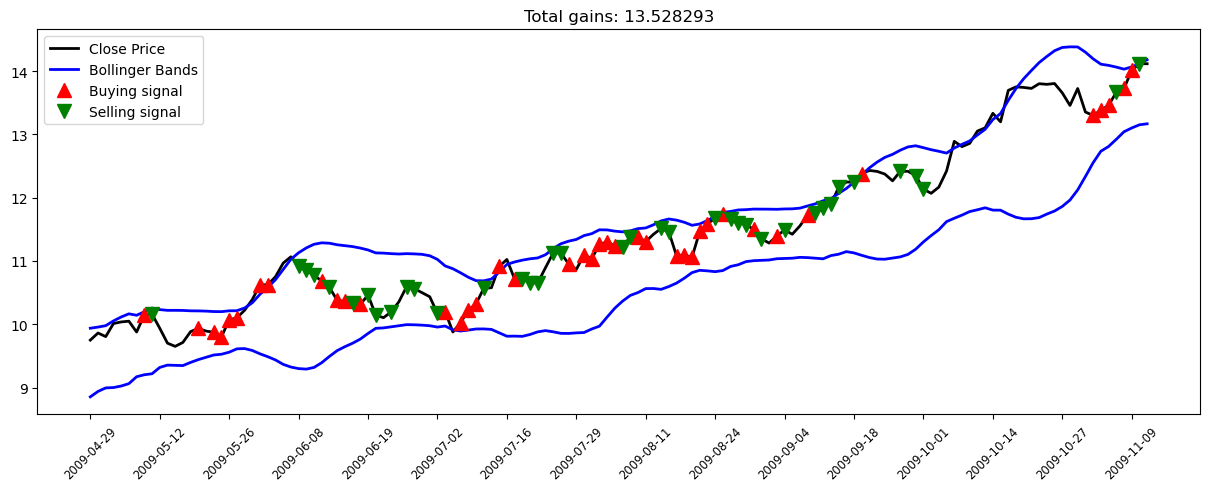

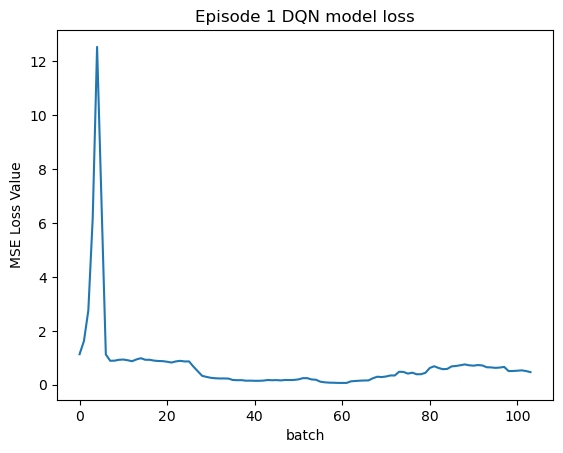

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Running episode 2/4:   0%|          | 0/137 [00:00<?, ?it/s]

Buy at $10.01━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Buy at $10.04━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sell at $9.88 | Trade profit: -$0.13━ 0s 19ms/step
Sell at $10.15 | Trade profit: $0.11━ 0s 18ms/step
Buy at $10.16━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $9.94━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $9.65 | Trade profit: -$0.51━ 0s 18ms/step
Sell at $9.71 | Trade profit: -$0.22━ 0s 17ms/step
Buy at $9.93━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sell at $9.89 | Trade profit: -$0.04━ 0s 24ms/step
Buy at $10.62━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $10.75 | Trade profit: $0.13━ 0s 17ms/step
Buy at $10.68━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $10.58 | Trade profit: -$0.10 0s 18ms/step
Buy at $10.15━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sell at $10.10 | Trade profit: -$0.04 0s 18ms/step
Buy at $10.50━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sell at $10.44 | Trade profit: -$0.06 0s 18ms/step
Buy at $10.20━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $9.88 | Trade profit: -$0.32━ 0s 18ms/step
Buy at $10.02━━━━━━━━━

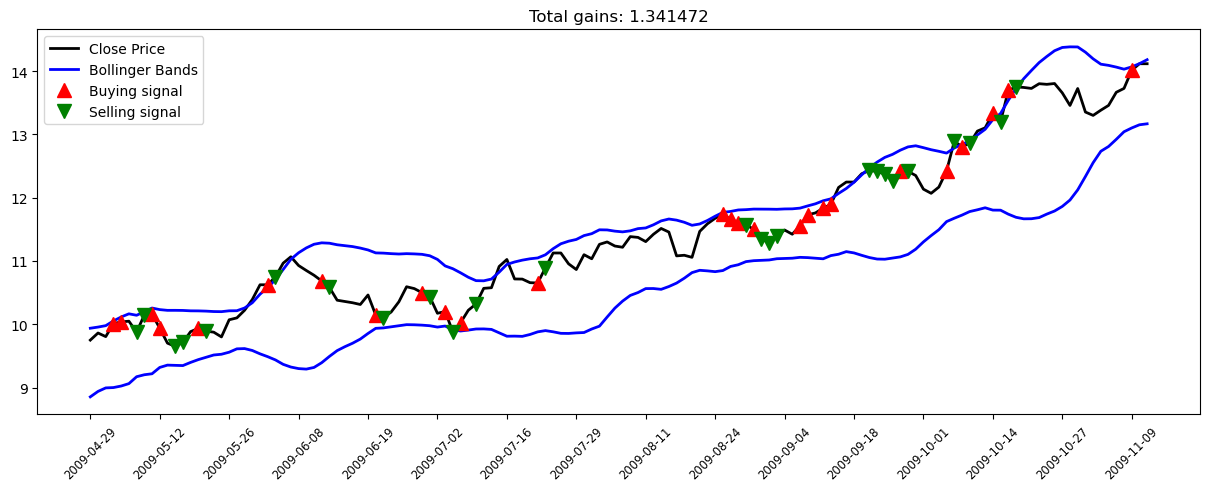

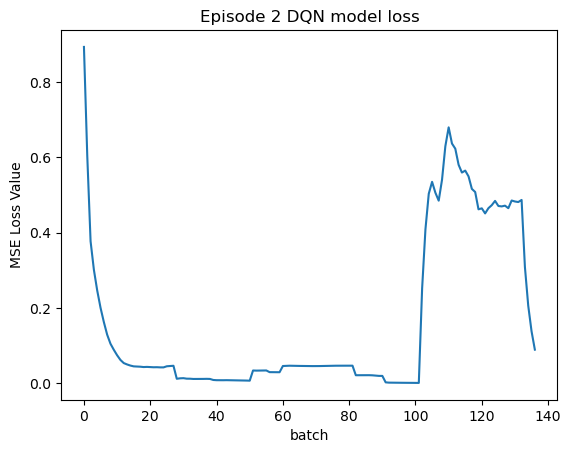

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Running episode 3/4:   0%|          | 0/137 [00:00<?, ?it/s]

Buy at $10.15━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.16━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $9.94━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $9.70 | Trade profit: -$0.44━ 0s 18ms/step
Sell at $9.71 | Trade profit: -$0.45━ 0s 17ms/step
Buy at $9.89━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Buy at $9.88━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sell at $9.80 | Trade profit: -$0.14━ 0s 16ms/step
Buy at $10.07━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $10.10 | Trade profit: $0.21━ 0s 17ms/step
Sell at $10.22 | Trade profit: $0.35━ 0s 18ms/step
Sell at $10.39 | Trade profit: $0.32━ 0s 20ms/step
Buy at $10.62━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sell at $10.62 | Trade profit: $0.00━ 0s 17ms/step
Buy at $10.31━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sell at $10.46 | Trade profit: $0.15━ 0s 19ms/step
Buy at $10.72━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.71━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Buy at $10.66━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Buy at $10.65━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Buy at $10.89━━━━━━━━━━━━━━━━━━

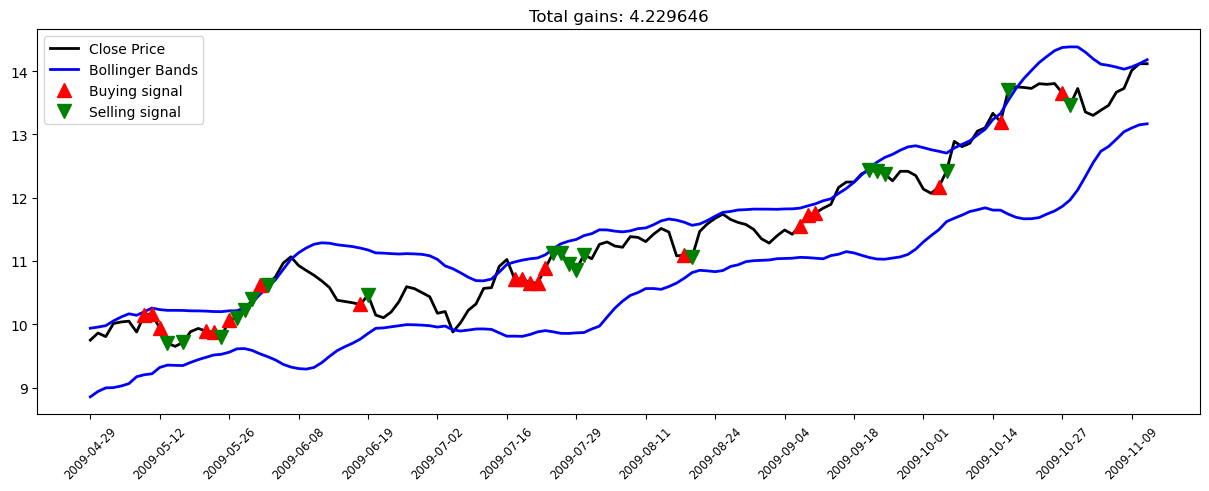

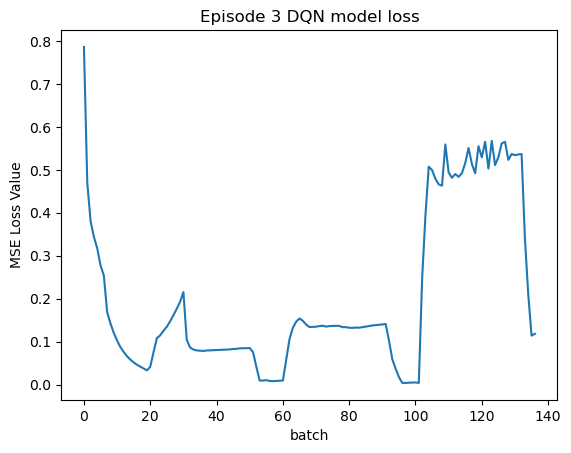

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Running episode 4/4:   0%|          | 0/137 [00:00<?, ?it/s]

Buy at $9.86━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $9.81━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.01━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.04━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $9.88 | Trade profit: $0.02━━ 0s 18ms/step
Sell at $10.16 | Trade profit: $0.36━ 0s 17ms/step
Sell at $9.94 | Trade profit: -$0.07━ 0s 19ms/step
Sell at $9.70 | Trade profit: -$0.33━ 0s 17ms/step
Buy at $10.56━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.50━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.44━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Buy at $10.17━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Buy at $10.20━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sell at $10.02 | Trade profit: -$0.54 0s 16ms/step
Sell at $10.22 | Trade profit: -$0.28 0s 17ms/step
Sell at $10.32 | Trade profit: -$0.11 0s 17ms/step
Sell at $10.58 | Trade profit: $0.40━ 0s 17ms/step
Sell at $10.91 | Trade profit: $0.71━ 0s 19ms/step
Buy at $11.59━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sell at $11.67 | Trade profit: $0.09━ 0s 18ms/step
Buy at $11.28━━━━━━━━━

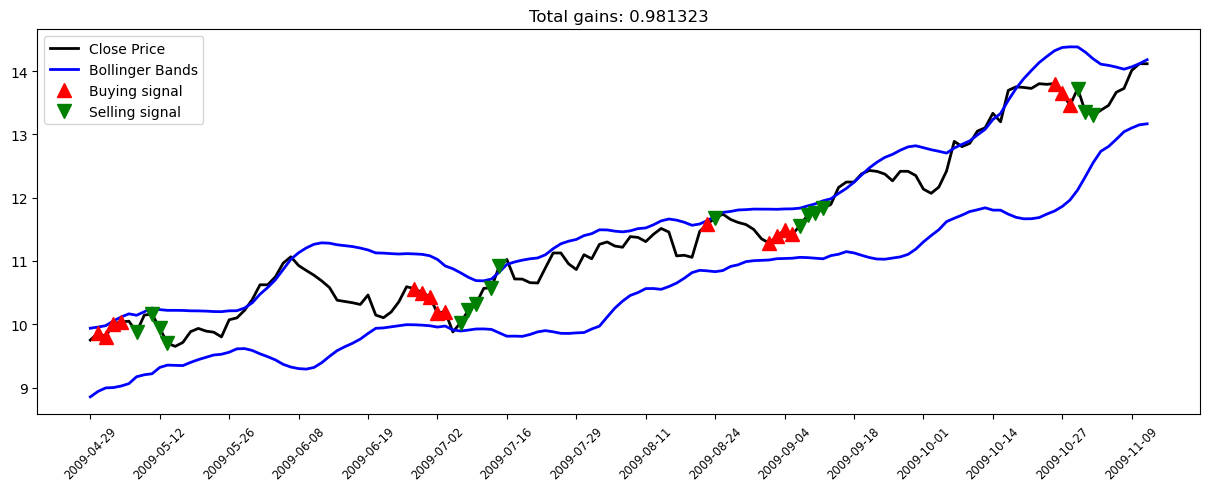

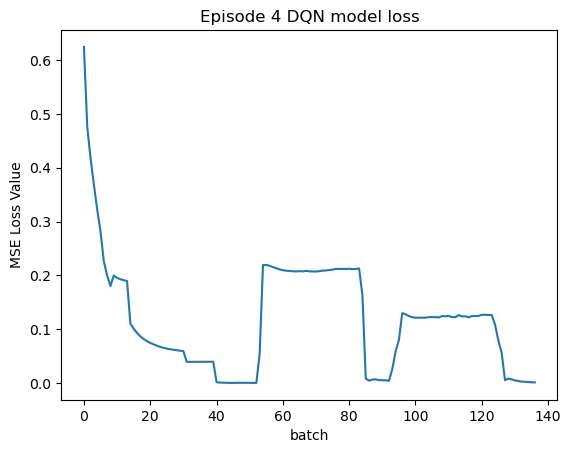

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

In [26]:
keras.config.disable_traceback_filtering() # disable built-in keras loading bars - they make the output difficult to read and monitor

# track number of examples in dataset (i.e. number of days to train on)
l = X_train.shape[0] - 1

# batch size defines how often to run the exp_replay method
batch_size = 32

# An episode represents a complete pass over the data.
episode_count = 4

# Compute the inverse transform of normalized feature values
X_train_true_price = normalizers['Close'].inverse_transform(X_train[:, index['Close']].reshape(-1, 1))
X_train_true_bb_upper = normalizers['BB_upper'].inverse_transform(X_train[:, index['BB_upper']].reshape(-1, 1))
X_train_true_bb_lower = normalizers['BB_lower'].inverse_transform(X_train[:, index['BB_lower']].reshape(-1, 1))

batch_losses = []
num_batches_trained = 0

for e in range(1, episode_count + 1):
    # get the state for the first step
    state = get_state(X_train, 0, window_size)
    # initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        # get the action
        action = agent.act(state)
        # get the next state
        next_state = get_state(X_train, t + 1, window_size)
        # initialize reward for the current time step
        reward = 0

        if action == 1: # buy
            # inverse transform to get true buy price in dollars
            buy_price = X_train_true_price[t][0]
            # append the buy price to the inventory
            agent.inventory.append(buy_price)
            # append the time step to states_buy
            states_buy.append(t)
            # print the action and price of the action
            print(f'Buy at {format_price(buy_price)}')

        elif action == 2 and len(agent.inventory) > 0: # sell
            # get the bought price of the stock you are selling (i.e. the stock at the beginning of the inventory)
            bought_price = agent.inventory.pop(0)
            # inverse transform to get true sell price in dollars
            sell_price = X_train_true_price[t][0]
            trade_profit = sell_price - bought_price
            # define reward as max of profit (close price at time of sell - close price at time of buy) and 0
            reward = max(trade_profit, 0)
            # add current profit to total profit
            total_profit += trade_profit
            if trade_profit >=0:
                # add current profit to total winners
                total_winners += trade_profit
            else:
                # add current profit to total losers
                total_losers += trade_profit
            # append the time step to states_sell
            states_sell.append(t)
            # print the action, price of the action, and profit of the action
            print(f'Sell at {format_price(sell_price)} | Trade profit: {format_price(trade_profit)}')
        
        # flag for final training iteration
        done = True if t == l - 1 else False

        # append the details of the state action etc in the memory, to be used by the exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
            print(f'Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        # when the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
        # then sum the losses for the batch and append them to the batch_losses list
        if len(agent.memory) > batch_size: # need batch_size + 1 datapoints
            losses = agent.exp_replay(batch_size)
            batch_losses.append(np.sum(losses))
            
    if e % 2 == 0:
        # save the model every 2 episodes (in case of crash or better training iteration in the middle of training process)
        agent.model.save(f'model_ep{e}.keras')


### Plot Training Loss

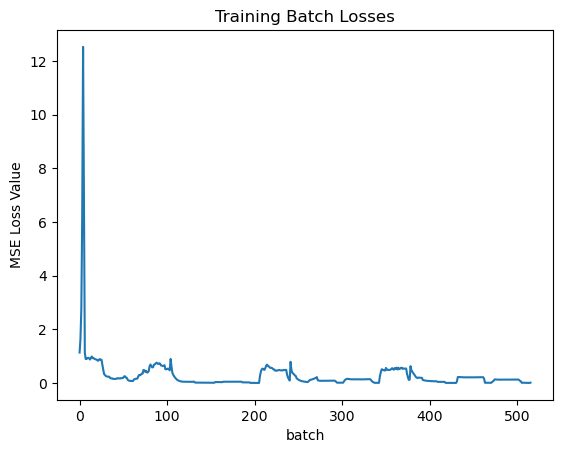

In [27]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, 'Training Batch Losses')

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [28]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

state = get_state(X_test, 0, window_size)

X_test_true_price = normalizers['Close'].inverse_transform(X_test[:, index['Close']].reshape(-1, 1))
X_test_true_bb_upper = normalizers['BB_upper'].inverse_transform(X_test[:, index['BB_upper']].reshape(-1, 1))
X_test_true_bb_lower = normalizers['BB_lower'].inverse_transform(X_test[:, index['BB_lower']].reshape(-1, 1))

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

------------------------------------------ 0s 17ms/step
Total Profit: $0.00
------------------------------------------


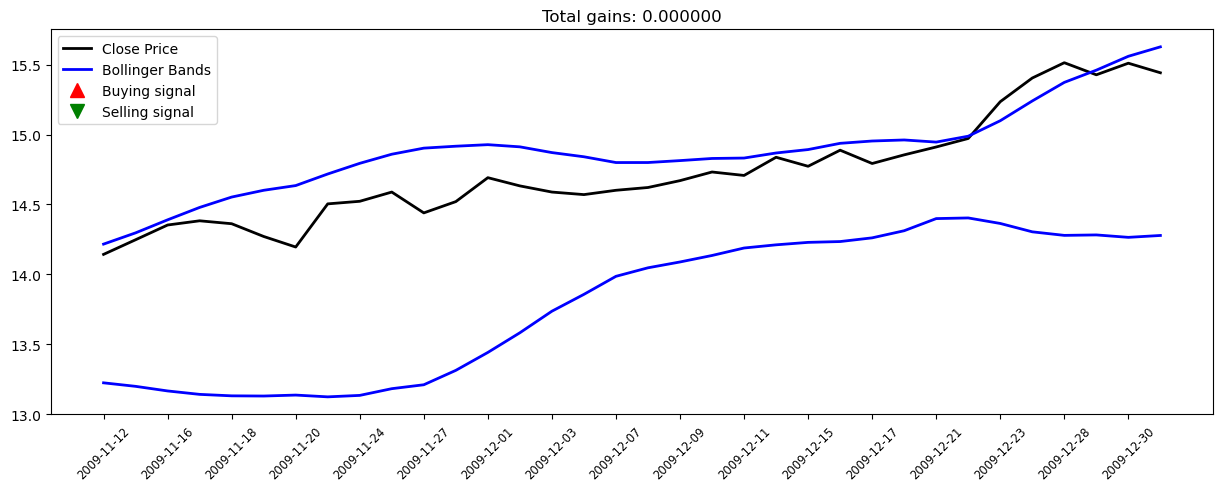

In [29]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size)
    reward = 0

    if action == 1: # buy
        # inverse transform to get true buy price in dollars
        buy_price = X_test_true_price[t][0]
        # append buy price to inventory
        agent.inventory.append(buy_price)
        # append time step to states_buy_test
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0: # sell
        # get bought price from beginning of inventory
        bought_price = agent.inventory.pop(0)
        # inverse transform to get true sell price in dollars
        sell_price = X_test_true_price[t][0]
        # reward is max of profit (close price at time of sell - close price at time of buy)
        trade_profit = sell_price - bought_price
        reward = max(trade_profit, 0)
        # update total_test_profit
        total_test_profit += trade_profit
        # append time step to states_sell_test
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')

    
    if t == l_test - 1:
        done = True
    # append to memory so we can re-train on 'live' (test) data later    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')
        
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)